# MAT281 - Laboratorio N°11

<a id='p1'></a>
## I.- Problema 01

Lista de actos delictivos registrados por el Service de police de la Ville de Montréal (SPVM).


<img src="http://henriquecapriles.com/wp-content/uploads/2017/02/femina_detenida-1080x675.jpg" width="480" height="360" align="center"/>

El conjunto de datos en estudio `interventionscitoyendo.csv` corresponde a  todos los delitos entre 2015 y agosto de 2020en Montreal. Cada delito está asociado en grandes categorías, y hay información sobre la ubicación, el momento del día, etc.

> **Nota**: Para más información seguir el siguiente el [link](https://donnees.montreal.ca/ville-de-montreal/actes-criminels).

In [1]:
# librerias 

import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from metrics_regression import *


# graficos incrustados
plt.style.use('fivethirtyeight')
%matplotlib inline

# parametros esteticos de seaborn
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (12, 4)})

In [2]:
# read data

validate_categorie = [
  'Introduction', 'Méfait','Vol dans / sur véhicule à moteur', 'Vol de véhicule à moteur',
]

df = pd.read_csv(os.path.join("interventionscitoyendo.csv"), sep=",", encoding='latin-1')
df.columns = df.columns.str.lower()
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

df = df.loc[lambda x: x['categorie'].isin(validate_categorie)]
df = df.sort_values(['categorie','date'])
df.head()

,categorie,date,quart,pdq,x,y,longitude,latitude
3462,Introduction,2015-01-01,jour,42.0,297210.375006,5.050179e+06,-73.597273,45.591480
8370,Introduction,2015-01-01,soir,13.0,297145.531007,5.032845e+06,-73.597834,45.435501
11968,Introduction,2015-01-01,nuit,8.0,289215.072000,5.036423e+06,-73.699308,45.467564
12763,Introduction,2015-01-01,soir,27.0,293203.472992,5.045436e+06,-73.648516,45.548740
13686,Introduction,2015-01-01,soir,44.0,298915.433995,5.046912e+06,-73.575381,45.562090


Como tenemos muchos datos por categoría a nivel de día, agruparemos a nivel de **semanas** y separaremos cada serie temporal.

In [3]:
cols = ['date','pdq']
y_s1 = df.loc[lambda x: x.categorie == validate_categorie[0] ][cols].set_index('date').resample('W').mean()
y_s2 = df.loc[lambda x: x.categorie == validate_categorie[1] ][cols].set_index('date').resample('W').mean()
y_s3 = df.loc[lambda x: x.categorie == validate_categorie[2] ][cols].set_index('date').resample('W').mean()
y_s4 = df.loc[lambda x: x.categorie == validate_categorie[3] ][cols].set_index('date').resample('W').mean()


El objetivo de este laboratorio es poder realizar un análisis completo del conjunto de datos en estudio, para eso debe responder las siguientes preguntas:

1. Realizar un gráfico para cada serie temporal $y\_{si}, i =1,2,3,4$.


Grafica y_s1:


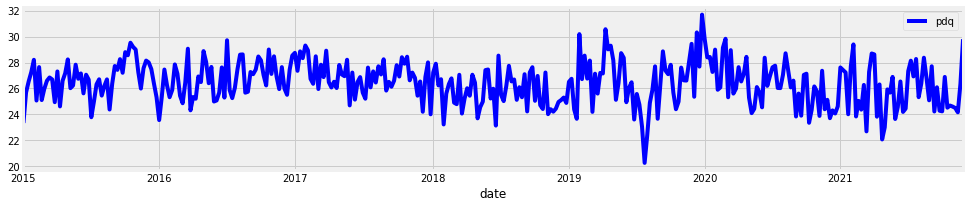

Grafica y_s2:


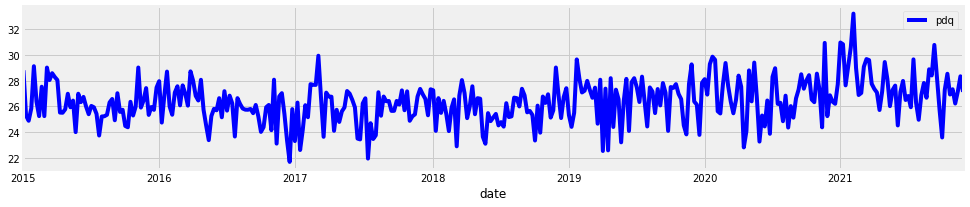

Grafica y_s3:


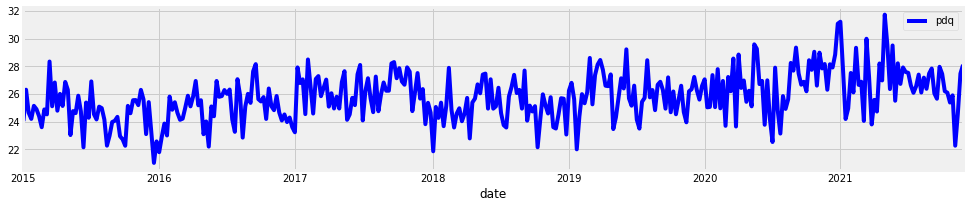

Grafica y_s4:


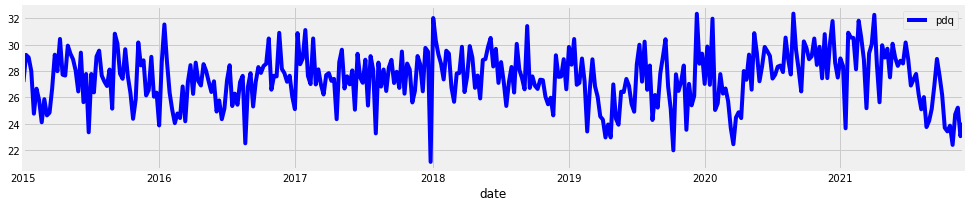

In [4]:
y_s1.plot(figsize=(15,3),color = "blue")
print("Grafica y_s1:")
plt.show()

y_s2.plot(figsize=(15,3),color = "blue")
print("Grafica y_s2:")
plt.show()

y_s3.plot(figsize=(15,3),color = "blue")
print("Grafica y_s3:")
plt.show()

y_s4.plot(figsize=(15,3),color = "blue")
print("Grafica y_s4:")
plt.show()

2. Escoger alguna serie temporal $y\_{si}, i =1,2,3,4$. Luego:

* Realice un análisis exploratorio de la serie temporal escogida
* Aplicar el modelo de pronóstico $SARIMA(p,d,q)x(P,D,Q,S)$, probando varias configuraciones de los hiperparámetros. Encuentre la mejor configuración. Concluya.
* Para el mejor modelo encontrado, verificar si el residuo corresponde a un ruido blanco.

> **Hint**: Tome como `target_date` =  '2021-01-01'. Recuerde considerar que su columna de valores se llama `pdq`.


In [5]:
# creando clase SarimaModels

class SarimaModels:
    def __init__(self,params):

        self.params = params
        
        
    @property
    def name_model(self):
        return f"SARIMA_{self.params[0]}X{self.params[1]}".replace(' ','')
    
    @staticmethod
    def test_train_model(y,date):
        mask_ds = y.index < date

        y_train = y[mask_ds]
        y_test = y[~mask_ds]        
        
        return y_train, y_test
    
    def fit_model(self,y,date):
        y_train, y_test = self.test_train_model(y,date )
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        
        model_fit = model.fit(disp=0)

        return model_fit
    
    def df_testig(self,y,date):
        y_train, y_test = self.test_train_model(y,date )
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        
        model_fit = model.fit(disp=0)
        
        start_index = y_test.index.min()
        end_index = y_test.index.max()

        preds = model_fit.get_prediction(start=start_index,end=end_index, dynamic=False)
        df_temp = pd.DataFrame(
            {
                'y':y_test['pdq'],
                'yhat': preds.predicted_mean
            }
        )
        
        return df_temp
    
    def metrics(self,y,date):
        df_temp = self.df_testig(y,date)
        df_metrics = summary_metrics(df_temp)
        df_metrics['model'] = self.name_model
        
        return df_metrics


Primero veamos la cantidad de valores unicos y vacios

  columna  unicos  vacios
0    date     361       0
1     pdq     359       0

Luego veamos entre que fechas esta nuestra serie escogida (y_s1) y algunos datos estadisticos del pdq

Fecha Inicial: 2015-01-04 00:00:00
Fecha Final: 2021-11-28 00:00:00

               pdq
count  361.000000
mean    26.437394
std      1.658831
min     20.255319
25%     25.227586
50%     26.515873
75%     27.611940
max     31.702479

Luego veamos cuantas entradas por fechas hay



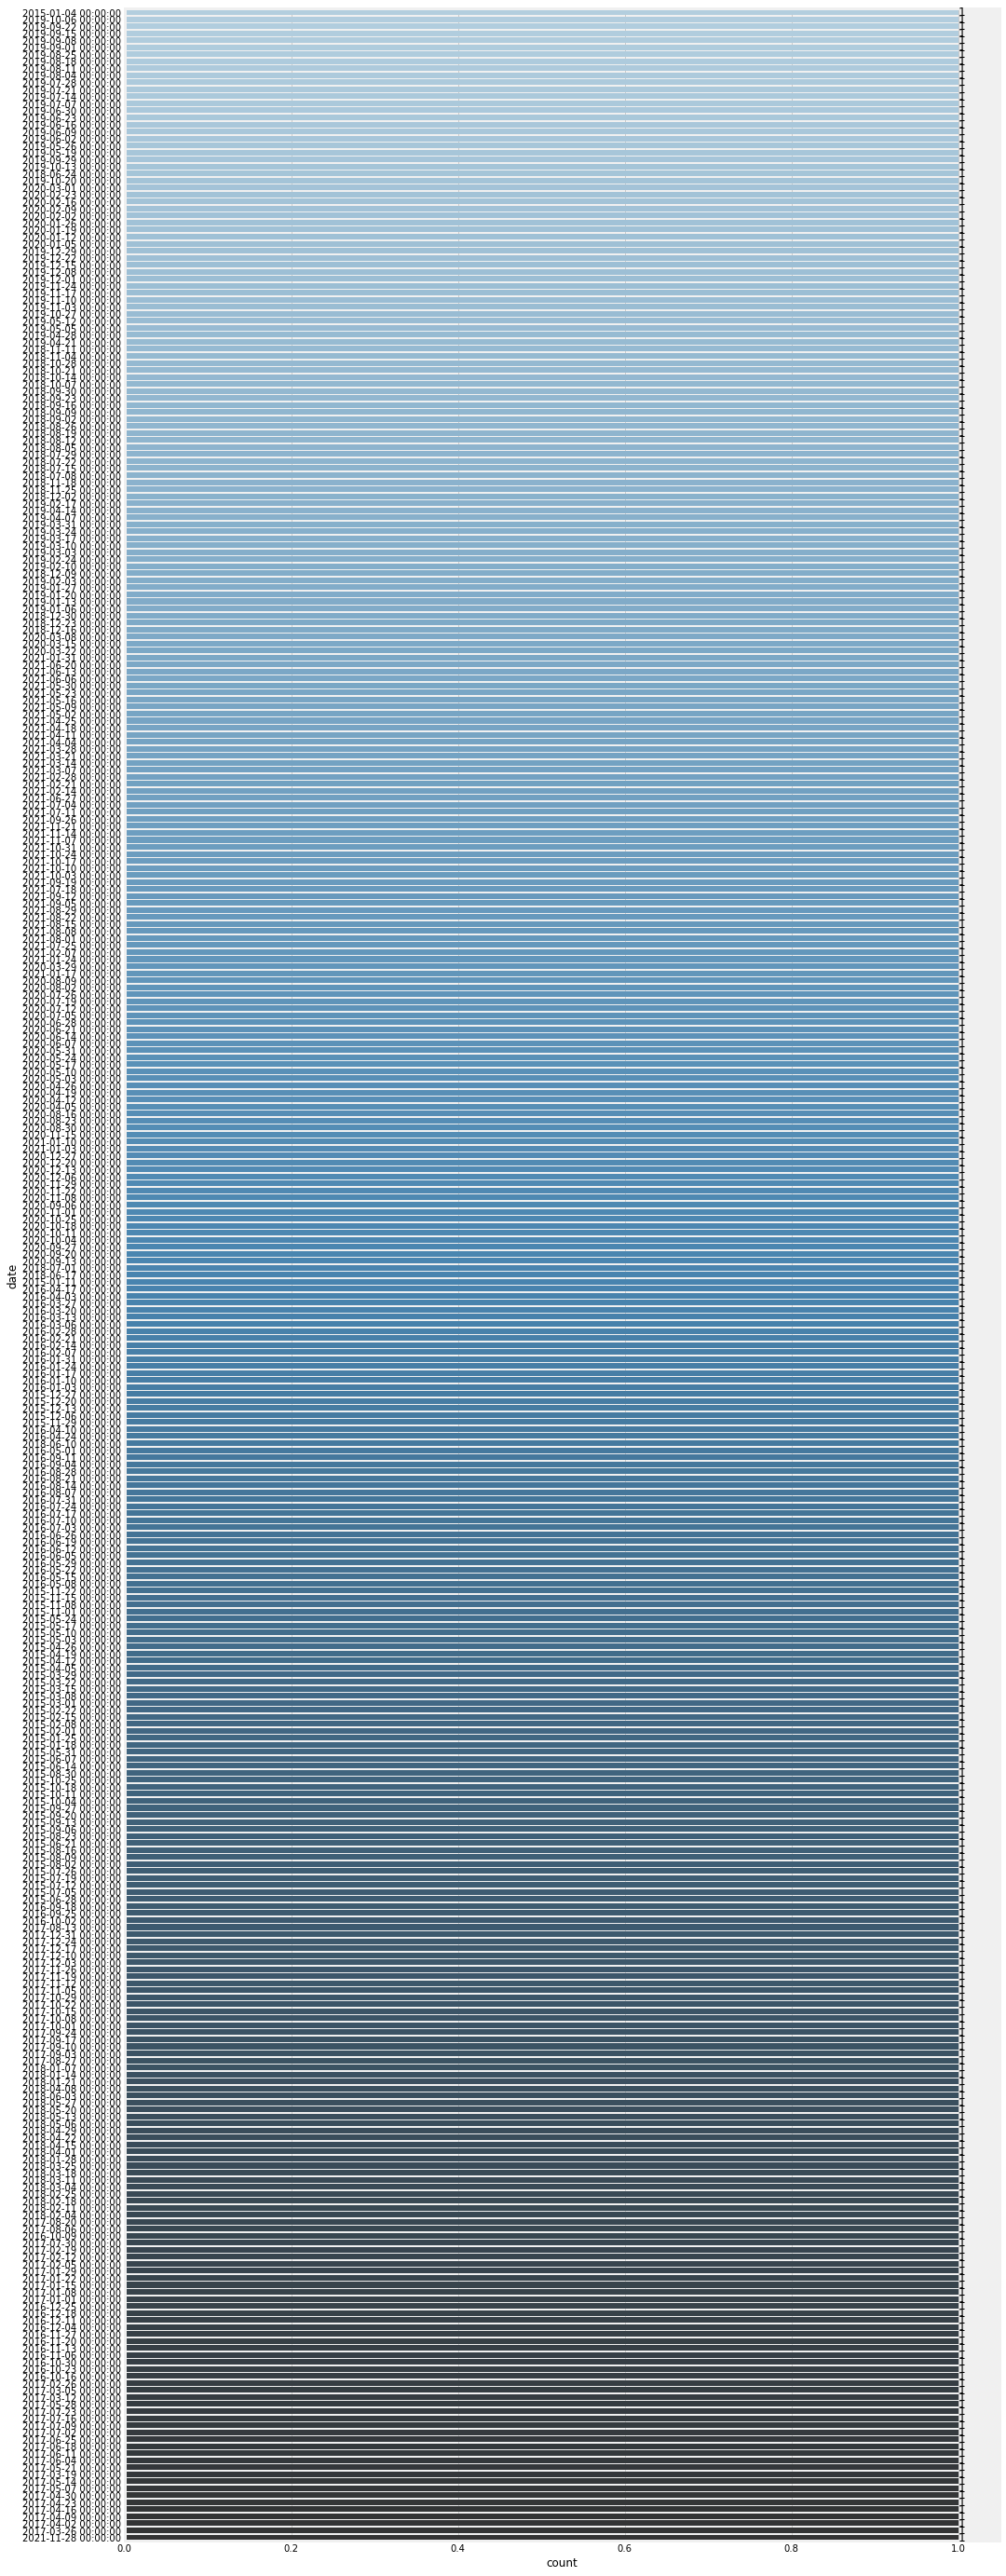

In [6]:
print("Primero veamos la cantidad de valores unicos y vacios\n") 

resumen = []
for columna in y_s1.reset_index().columns:
    unico = y_s1.reset_index()[columna].unique()
    vacio = y_s1.reset_index()[columna][y_s1.reset_index()[columna].isna()]
    
    info = pd.DataFrame({
        "columna": [columna],
        "unicos": [len(unico)],
        "vacios": [len(vacio)]
    })
    resumen.append(info)
info_dataframe = pd.concat(resumen).reset_index(drop=True)
print(info_dataframe)

print("\nLuego veamos entre que fechas esta nuestra serie escogida (y_s1) y algunos datos estadisticos del pdq\n")

print("Fecha Inicial: {}\nFecha Final: {}".format(y_s1.reset_index().date.min(),y_s1.reset_index().date.max()))
print("\n",y_s1.reset_index().describe())

print("\nLuego veamos cuantas entradas por fechas hay\n")

plt.figure(figsize=(15,50))
plotting = sns.countplot(
    y = "date",
    data = y_s1.reset_index(),
    order = y_s1.reset_index()["date"].value_counts().index,
    palette = "Blues_d",
)
for cont in plotting.containers:
    plotting.bar_label(cont,fontsize=12)
    plt.show

Como se puede ver cada fecha se repite una vez. Esto se puede comprobar viendo que el dataframe y_s1 tiene 361 entradas y hay 361 valores unicos en la columna "date". Y por otra parte al ver el grafico es facil ver que no es estacionaria. Veamos esto usando el test de Dickey-Fuller.

Luego empezamos a aplicar el modelo de pronostico SARIMA(p,d,q)x(P,D,Q,S), para esto empezamos seleccionando la muestra train y test usando la fecha indicada.

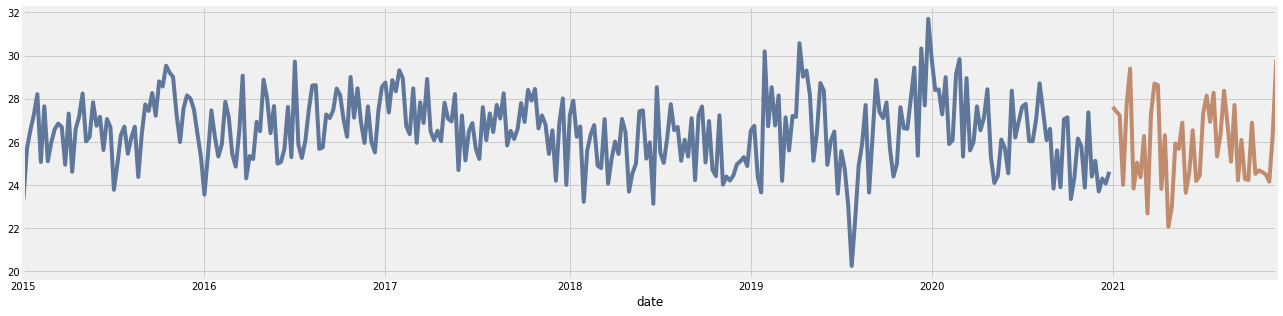

In [7]:
plt.figure(figsize=(20,5))
target_date = '2021-01-01'

mask = y_s1.index < target_date

y_train = y_s1[mask]
y_test = y_s1[~mask]

y_train["pdq"].plot()
y_test["pdq"].plot()
#Se muestra la grafica de las muestras que se usaran
plt.show()

/home/ripvanfish/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
/tmp/ipykernel_25946/3177124983.py:24: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  ax = y_s1["2021"].plot(label="observed")


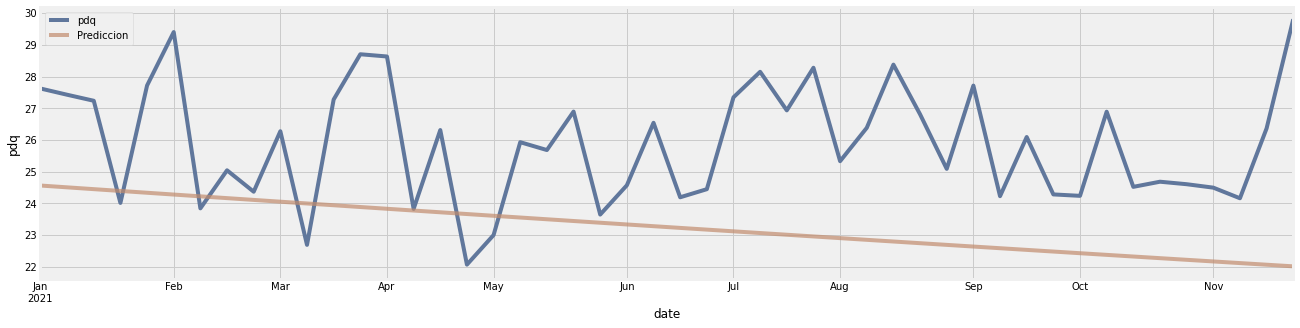

,mae,mse,rmse,mape,maape,wmape,mmape,smape,model
0,2.7904,10.5785,3.2525,0.1044,0.1036,0.1078,0.1006,0.1118,"SARIMA_(1,0,0)X(0,0,0,12)"


In [8]:
#Luego empezamos con el modelamiento en si, primero veremos 2 casos arbitrarios.
parametros = [(1,0,0),(0,0,0,12)]
model = SARIMAX(y_train,
               order=parametros[0],
               seasonal_order=parametros[1],
               enforce_stationarity=False,
               enforce_invertibility=False)

model_fit = model.fit(disp=0)

start_index = y_test.index.min()
end_index = y_test.index.max()

preds = model_fit.get_prediction(start=start_index,end=end_index,dynamic=False)
df_temp = pd.DataFrame(
    {
        "y":y_test["pdq"],
        "yhat": preds.predicted_mean
    }
)

#Luego comparamos la prediccion del modelo con el grafico original
preds = df_temp["yhat"]
ax = y_s1["2021"].plot(label="observed")
preds.plot(ax=ax,label="Prediccion",alpha=.7,figsize=(20,5))
ax.set_xlabel("date")
ax.set_ylabel("pdq")
plt.legend()
plt.show()
# Y vemos las metricas
y_metrics = summary_metrics(df_temp)
y_metrics["model"] = f"SARIMA_{parametros[0]}X{parametros[1]}".replace(" ","")
y_metrics

Como se puede ver la prediccion no es muy buena, esto se comprueba viendo las metricas, en especial mae y mse, 
ahora usemos ahora otros parametros.

/home/ripvanfish/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
/tmp/ipykernel_25946/3097080918.py:23: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  ax = y_s1["2021"].plot(label="observed")


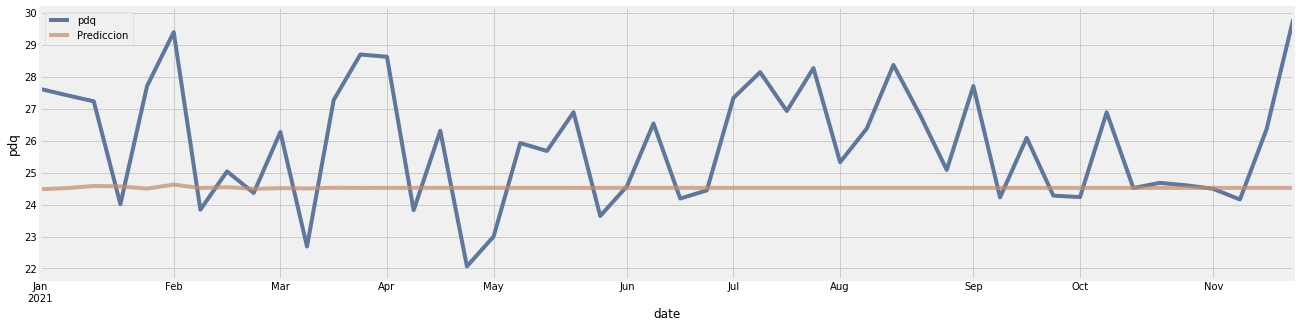

,mae,mse,rmse,mape,maape,wmape,mmape,smape,model
0,1.7832,5.1895,2.2781,0.0661,0.0658,0.0689,0.0637,0.0692,"SARIMA_(0,1,0)X(1,0,0,12)"


In [9]:
parametros = [(0,1,0),(1,0,0,12)]
model = SARIMAX(y_train,
               order=parametros[0],
               seasonal_order=parametros[1],
               enforce_stationarity=False,
               enforce_invertibility=False)

model_fit = model.fit(disp=0)

start_index = y_test.index.min()
end_index = y_test.index.max()

preds = model_fit.get_prediction(start=start_index,end=end_index,dynamic=False)
df_temp = pd.DataFrame(
    {
        "y":y_test["pdq"],
        "yhat": preds.predicted_mean
    }
)

#Luego comparamos la prediccion del modelo con el grafico original
preds = df_temp["yhat"]
ax = y_s1["2021"].plot(label="observed")
preds.plot(ax=ax,label="Prediccion",alpha=.7,figsize=(20,5))
ax.set_xlabel("date")
ax.set_ylabel("pdq")
plt.legend()
plt.show()
# Y vemos las metricas
y_metrics = summary_metrics(df_temp)
y_metrics["model"] = f"SARIMA_{parametros[0]}X{parametros[1]}".replace(" ","")
y_metrics

Es un poco mejor pero no perfecta, mae y mse pasaron de (2.7904 , 10.5785) a (1.7832 , 5.1895) respectivamente.

Para encontrar los mejores parametros iteraremos estos.

In [10]:
import itertools

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

params = list(itertools.product(pdq,seasonal_pdq))

frames = []
for param in params:
    try:
        sarima_model = SarimaModels(param)
        y_metrics = sarima_model.metrics(y_s1,target_date)
        frames.append(y_metrics)
    except:
        pass

/home/ripvanfish/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
/home/ripvanfish/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Y con esto ahora juntamos las metricas, tomando en cuenta mae y mse para ordenarlas. Asi quedaran los mejores parametros primero

In [11]:
y_metrics_result = pd.concat(frames)
y_metrics_result.sort_values(["mae","mse"])

,mae,mse,rmse,mape,maape,wmape,mmape,smape,model
0,1.5876,3.4224,1.8500,0.0622,0.0620,0.0614,0.0599,0.0614,"SARIMA_(0,0,0)X(1,0,1,12)"
0,1.5934,3.4304,1.8521,0.0624,0.0622,0.0616,0.0600,0.0616,"SARIMA_(0,0,1)X(1,0,1,12)"
0,1.6021,3.4537,1.8584,0.0627,0.0625,0.0619,0.0603,0.0619,"SARIMA_(1,0,0)X(1,0,1,12)"
0,1.6444,3.7832,1.9451,0.0654,0.0651,0.0635,0.0629,0.0635,"SARIMA_(0,0,0)X(0,1,1,12)"
0,1.6444,3.7833,1.9451,0.0654,0.0651,0.0635,0.0629,0.0635,"SARIMA_(0,0,0)X(1,1,1,12)"
...,...,...,...,...,...,...,...,...,...
0,7.8111,73.7850,8.5898,0.2988,0.2862,0.3019,0.2877,0.3654,"SARIMA_(1,1,0)X(0,1,0,12)"
0,22.8403,550.3448,23.4594,0.8845,0.7122,0.8827,0.8514,1.6822,"SARIMA_(0,0,1)X(0,0,1,12)"
0,23.0209,560.5370,23.6757,0.8899,0.7147,0.8896,0.8567,1.7030,"SARIMA_(0,0,0)X(0,0,1,12)"
0,25.5633,660.3857,25.6980,0.9886,0.7779,0.9879,0.9517,1.9706,"SARIMA_(0,0,1)X(0,0,0,12)"


Como se puede ver las mejores metricas son SARIMA_(0,0,0)X(1,0,1,12)

/home/ripvanfish/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
/tmp/ipykernel_25946/3565350563.py:23: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  ax = y_s1["2021"].plot(label="observed")


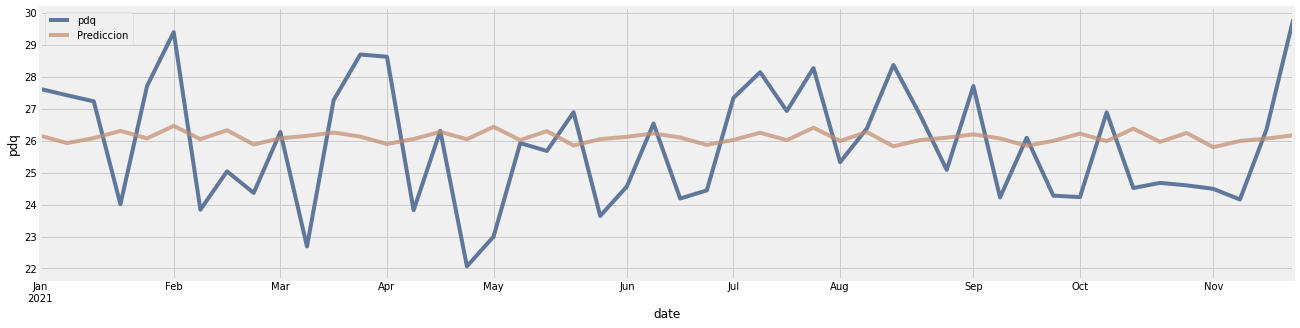

In [12]:
parametros = [(0,0,0),(1,0,1,12)]
model = SARIMAX(y_train,
               order=parametros[0],
               seasonal_order=parametros[1],
               enforce_stationarity=False,
               enforce_invertibility=False)

model_fit = model.fit(disp=0)

start_index = y_test.index.min()
end_index = y_test.index.max()

preds = model_fit.get_prediction(start=start_index,end=end_index,dynamic=False)
df_temp = pd.DataFrame(
    {
        "y":y_test["pdq"],
        "yhat": preds.predicted_mean
    }
)

#Luego comparamos la prediccion del modelo con el grafico original
preds = df_temp["yhat"]
ax = y_s1["2021"].plot(label="observed")
preds.plot(ax=ax,label="Prediccion",alpha=.7,figsize=(20,5))
ax.set_xlabel("date")
ax.set_ylabel("pdq")
plt.legend()
plt.show()

Como se puede ver el modelo no se ajusta bien al grafico, por lo tanto, si se quiere obtener una mejor prediccion se deberia elegir otra forma de modelar. 